#### Imports and Setup

In [5]:
# OPENAI_API_KEY = None
import sys
sys.path.append('/Users/shashankkumar/Documents/GitHub/MacroEcon/AgentTorch')
from AgentTorch.LLM.llm_qa import DocumentRetriever,SimulationAnalysisAgent
import dspy
from typing import List, Union, Optional
from dsp.utils import deduplicate
import pickle
import torch
import numpy as np
import pandas as pd
import os
import pandas as pd
from pandasai import SmartDataframe
from pandasai.llm import OpenAI
from pandasai import Agent
from langchain import hub
from langchain import hub
# Get the prompt to use - you can modify this!



In [2]:
# OPENAI_API_KEY = None
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
directory = "/Users/shashankkumar/Documents/GitHub/MacroEcon/simulator_data/census_populations/NYC/simulation_input/simulation_memory_output/2019/1"
search_kwargs = {"k": 10}
document_retriever = DocumentRetriever(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs,directory=directory, search_kwargs=search_kwargs)

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [6]:
state_trace_path = "/Users/shashankkumar/Documents/GitHub/MacroEcon/state_data_dict.pkl"
prompt = hub.pull("hwchase17/openai-functions-agent")
analysis_agent = SimulationAnalysisAgent(openai_api_key=OPENAI_API_KEY, document_retriever=document_retriever, temperature=0, state_trace_path=state_trace_path,prompt=prompt)

/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/langchain_community/llms/openai.py:249: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(
/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/langchain_community/llms/openai.py:1070: UserWarning: You are trying to use a chat model. This way of initializing it is no longer supported. Instead, please use: `from langchain_community.chat_models import ChatOpenAI`
  warnings.warn(


ValueError: This function requires a .bind_tools method be implemented on the LLM.

#### Langchain Query Runner

In [ ]:
query_runner = QueryRunner(retriever=document_retriever.retriever,openai_api_key=OPENAI_API_KEY)
query_runner(query="What is the approximate consumption rate")

#### Dspy Query 

In [ ]:
from AgentTorch.LLM.llm_qa import DSPythonicRMClient, QueryRunnerUsingDspy

rm = DSPythonicRMClient(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs,directory=directory,search_kwargs=search_kwargs)
turbo = dspy.OpenAI(model='gpt-3.5-turbo', api_key=OPENAI_API_KEY)
dspy.settings.configure(lm=turbo, rm=rm)
# Ask any question you like to this simple RAG program.
my_question = "How many age groups are there in the population?"

# Get the prediction. This contains `pred.context` and `pred.answer`.
query_runner = QueryRunnerUsingDspy()  # uncompiled (i.e., zero-shot) program
pred = query_runner(my_question)

# Print the contexts and the answer.
print(f"Question: {my_question}")
print(f"Predicted Answer: {pred.answer}")
print(f"Retrieved Contexts (truncated): {[c[:200] + '...' for c in pred.context]}")

### Pandas AI

In [ ]:
model_name = "BAAI/bge-small-en"
model_kwargs = {"device": "cpu"}
encode_kwargs = {"normalize_embeddings": True}
directory = "/Users/shashankkumar/Documents/GitHub/MacroEcon/simulator_data/census_populations/NYC/simulation_input/simulation_memory_output/2019"
search_kwargs = {"k": 5}
document_retriever = DocumentRetriever(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs,directory=directory, search_kwargs=search_kwargs)

In [11]:
from langchain_openai import ChatOpenAI
from langchain_core.prompts import ChatPromptTemplate
import os

# Initialize the OpenAI chat model
openai_chat_model = ChatOpenAI(api_key=OPENAI_API_KEY, model_name="gpt-4")

system_prompt = """You are a data analyst responsible for breaking down complex queries into smaller, more manageable subqueries. Your task is to take a given query and split it into a series of subqueries, each building upon the previous one(s), except for the last subquery, which should use the results from the previous subqueries to generate the final answer.

For each subquery, provide a clear and concise description of the data or information needed, without including any code. These descriptions will be used by other agents to generate the appropriate Pandas code for retrieving the required data.

Your output should be a JSON object with keys representing each subquery, and the corresponding values being the descriptions for those subqueries. The number of subqueries can vary depending on the complexity of the original query, so you should dynamically create the appropriate number of keys in the JSON object.

For example, if you have three subqueries, your JSON output should look like this:

{{
  "subquery1": "Description for subquery 1",
  "subquery2": "Description for subquery 2",
  "subquery3": "Description for subquery 3"
}}

Remember, your goal is to provide clear and concise descriptions for each subquery, without including any code. The generated JSON object will be used by other agents to retrieve the necessary data and ultimately generate the final answer to the original query."""
# Define the prompt template
prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("user", "{input}")
])

# Create a processing chain with the prompt template and the OpenAI chat model
processing_chain = prompt_template | openai_chat_model

In [ ]:
out = processing_chain.invoke({"input": "What is the approximate consumption rate for old aged people in the population?"})

In [ ]:
processing_chain.invoke({"input": "What is the consumption trend for females?"})

Load state variables and Initialise Pandas Agent

In [6]:
with open('/Users/shashankkumar/Documents/GitHub/MacroEcon/state_data_dict.pkl', 'rb') as handle:
    sim_data_dict = pickle.load(handle)

In [ ]:
sim_data_dict[4]

Loading Environment Properties

In [16]:
import pandas as pd

# Initialize an empty list to store the data
data = []

# Iterate over the items in the dictionary
for timestep, values in sim_data_dict[4]['environment'].items():
    # Extract the unemployment rates for months
    unemployment_rate_bronx = values['Unemployment_Rate_BRONX'].detach().numpy()[0]
    unemployment_rate_brooklyn = values['Unemployment_Rate_BROOKLYN'].detach().numpy()[0]
    unemployment_rate_queens = values['Unemployment_Rate_Queens'].detach().numpy()[0]
    unemployment_rate_manhattan = values['Unemployment_Rate_Manhattan'].detach().numpy()[0]
    unemployment_rate_staten_island = values['Unemployment_Rate_Staten_Island'].detach().numpy()[0]

    # Append the data to the list
    data.append([timestep, unemployment_rate_bronx, unemployment_rate_brooklyn, unemployment_rate_queens, unemployment_rate_manhattan, unemployment_rate_staten_island])

# Convert the list to a DataFrame
df = pd.DataFrame(data, columns=['Timestep', 'Unemployment Rate Bronx', 'Unemployment Rate Brooklyn', 'Unemployment Rate Queens', 'Unemployment Rate Manhattan', 'Unemployment Rate Staten Island'])
df = df[df['Timestep'] == 4]
df

,Timestep,Unemployment Rate Bronx,Unemployment Rate Brooklyn,Unemployment Rate Queens,Unemployment Rate Manhattan,Unemployment Rate Staten Island
4,4,"[36.422546, 35.82621, 35.73896, 33.828674, 33....","[56.97322, 57.56573, 57.657307, 57.88019, 57.9...","[37.994762, 48.370365, 39.547115, 48.064587, 3...","[48.765392, 39.52357, 48.095665, 39.295048, 47...","[19.079235, 19.065283, 18.862564, 18.429714, 1..."


In [18]:
pandas_agent = get_pandas_agent(agent_prop_df_list=df, llm=openai_llm)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


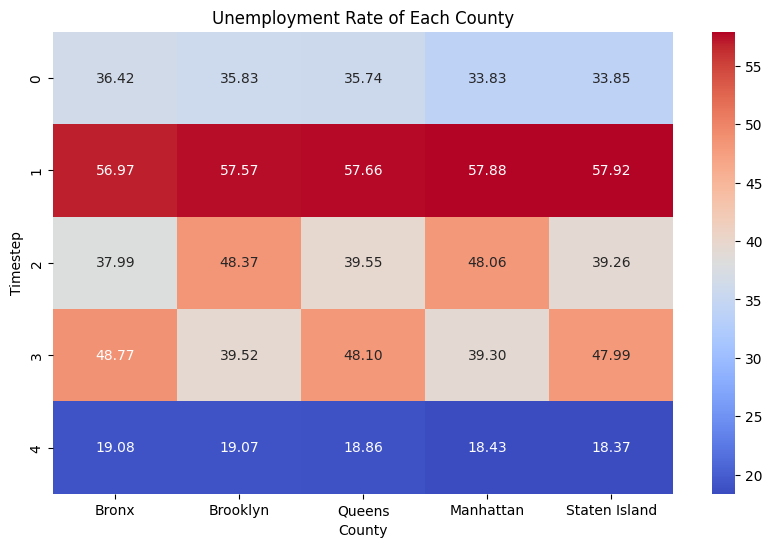

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'/Users/shashankkumar/Documents/GitHub/MacroEcon/AgentTorch/exports/charts/temp_chart.png'

In [20]:
pandas_agent.chat("Plot the unemployment rate of each county on a heat map")

In [8]:
def load_state_dict(sim_data_dict):
    agent_prop_df_list = []
    for episode in sim_data_dict.keys():
        print(sim_data_dict[episode]['agents'].keys())
        agent_prop_dict = sim_data_dict[episode]['agents']
        for step, agent_prop in agent_prop_dict.items():
            processed_data = {'consumers':{}}
            for key, value in agent_prop['consumers'].items():
                value = value.flatten().squeeze()
                processed_data['consumers'][key] = value.numpy()
            processed_data['consumers']['assets'] = processed_data['consumers']['assets'][:541516]
            df = pd.DataFrame(processed_data['consumers'])
            # Flatten the nested structure
            df = df.explode(['assets', 'consumption_propensity', 'monthly_consumption', 'monthly_income', 'post_tax_income', 'will_work', 'work_propensity'])
            # Ensure consistent data types
            df = df.astype({'ID': int, 'age': float, 'area': float, 'assets': float, 'consumption_propensity': float, 'ethnicity': float, 'gender': float, 'monthly_consumption': float, 'monthly_income': float, 'post_tax_income': float, 'will_work': float, 'work_propensity': float,'household_id': int})
            df = df.drop('work_propensity', axis=1)
            df= df.drop('monthly_consumption', axis=1)
            df['month'] = step
            df['year'] = episode
            mapping  = { 
            "age": ["20t29", "30t39", "40t49", "50t64", "65A", "U19"], 
            "gender": ["male", "female"], 
            "ethnicity": ["hispanic", "asian", "black", "white", "other", "native"], 
            "county": ["BK", "BX", "MN", "QN", "SI"]
        }
        # Reverse the mapping to map from index to value
            reverse_mapping = {col: {i: val for i, val in enumerate(vals)} for col, vals in mapping.items()}
        # Replace the values in the DataFrame
            df.replace(reverse_mapping, inplace=True)
            agent_prop_df_list.append(df)
    return agent_prop_df_list



dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4])
dict_keys([0, 1, 2, 3, 4])


In [38]:
def load_state_trace(sim_data_dict):
    agent_prop_df_list = []

    # Loop through each episode in the simulation data dictionary
    for episode in sim_data_dict.keys():
        agent_prop_dict = sim_data_dict[episode]['agents']

        # Loop through each step and agent properties in the episode
        for step, agent_prop in agent_prop_dict.items():
            processed_data = {'consumers': {}}

            # Extract consumer data from the agent properties
            for key, value in agent_prop['consumers'].items():
                value = value.flatten().squeeze()
                processed_data['consumers'][key] = value.numpy()

            # Limit the 'assets' column to the first 541516 entries
            processed_data['consumers']['assets'] = processed_data['consumers']['assets'][:541516]

            # Create a DataFrame from the processed consumer data
            consumer_df = pd.DataFrame(processed_data['consumers'])

            # Explode (flatten) the nested columns
            consumer_df = consumer_df.explode(['assets', 'consumption_propensity', 'monthly_income', 'post_tax_income', 'will_work'])

            # Ensure consistent data types for the DataFrame columns
            consumer_df = consumer_df.astype({'ID': int, 'age': float, 'area': float, 'assets': float, 'consumption_propensity': float,
                                              'ethnicity': float, 'gender': float, 'monthly_income': float, 'post_tax_income': float,
                                              'will_work': float, 'household_id': int})

            # Remove unnecessary columns
            consumer_df = consumer_df.drop(['work_propensity', 'monthly_consumption'], axis=1)

            # Add month and year columns based on the current step and episode
            consumer_df['month'] = step
            consumer_df['year'] = episode

            # Mapping for categorical variables
            mapping = {
                "age": ["20t29", "30t39", "40t49", "50t64", "65A", "U19"],
                "gender": ["male", "female"],
                "ethnicity": ["hispanic", "asian", "black", "white", "other", "native"],
                "county": ["BK", "BX", "MN", "QN", "SI"]
            }

            # Reverse the mapping for replacement
            reverse_mapping = {col: {i: val for i, val in enumerate(vals)} for col, vals in mapping.items()}

            # Replace numerical values with categorical labels in the DataFrame
            consumer_df.replace(reverse_mapping, inplace=True)

            # Append the current consumer DataFrame to the list
            agent_prop_df_list.append(consumer_df)

    return agent_prop_df_list
load_state_trace(sim_data_dict)

[            ID    age  area county  household_id  assets  \
 0            0  20t29   0.0     BK             0     0.0   
 1            1  20t29   0.0     BK             1     0.0   
 2            2  20t29   0.0     BK             2     0.0   
 3            3  20t29   0.0     BK             3     0.0   
 4            4  20t29   0.0     BK             4     0.0   
 ...        ...    ...   ...    ...           ...     ...   
 541511  541511    U19  10.0     SI          9717     0.0   
 541512  541512    U19  10.0     SI         12690     0.0   
 541513  541513    U19  10.0     SI         10838     0.0   
 541514  541514    U19  10.0     SI         18473     0.0   
 541515  541515    U19  10.0     SI          1122     0.0   
 
         consumption_propensity ethnicity  gender  monthly_income  \
 0                          0.0  hispanic    male             0.0   
 1                          0.0     asian  female             0.0   
 2                          0.0  hispanic  female          

In [42]:
with open('/Users/shashankkumar/Documents/GitHub/MacroEcon/state_data_dict.pkl', 'rb') as handle:
    sim_data_dict = pickle.load(handle)
agent_prop = sim_data_dict['agents']
env_prop = sim_data_dict['environment']

processed_data = {'consumers':{}}
for key, value in agent_prop['consumers'].items():
    value = value.flatten().squeeze()
    processed_data['consumers'][key] = value.numpy()
processed_data['consumers']['assets'] = processed_data['consumers']['assets'][:541516]
df = pd.DataFrame(processed_data['consumers'])
# Flatten the nested structure
df = df.explode(['assets', 'consumption_propensity', 'monthly_consumption', 'monthly_income', 'post_tax_income', 'will_work', 'work_propensity'])
# Ensure consistent data types
df = df.astype({'ID': int, 'age': float, 'area': float, 'assets': float, 'consumption_propensity': float, 'ethnicity': float, 'gender': float, 'monthly_consumption': float, 'monthly_income': float, 'post_tax_income': float, 'will_work': float, 'work_propensity': float,'household_id': int})
df = df.drop('work_propensity', axis=1)
df= df.drop('monthly_consumption', axis=1)

openai_llm = OpenAI(
    api_token=OPENAI_API_KEY,
)
mapping  = { 
    "age": ["20t29", "30t39", "40t49", "50t64", "65A", "U19"], 
    "gender": ["male", "female"], 
    "ethnicity": ["hispanic", "asian", "black", "white", "other", "native"], 
    "county": ["BK", "BX", "MN", "QN", "SI"]
}

# Reverse the mapping to map from index to value
reverse_mapping = {col: {i: val for i, val in enumerate(vals)} for col, vals in mapping.items()}

# Replace the values in the DataFrame
df.replace(reverse_mapping, inplace=True)
dfs = SmartDataframe(df,config={"llm": openai_llm})

In [ ]:
def get_pandas_agent(agent_prop_df_list, llm):
    # Create and return the PandasAI Agent instance
    return Agent(agent_prop_df_list, config={"llm": llm})
openai_llm = OpenAI(
    api_token=OPENAI_API_KEY,
    )
pandas_agent = get_pandas_agent(agent_prop_df_list=, llm=openai_llm)

In [ ]:
for query in out:
    print(agent.chat(agent.rephrase_query(out[query])),query)

In [36]:
pandas_agent.chat("What are the gender types?")

'Gender types: [0. 1.]'

In [23]:
len(agent_prop_df_list)

25

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


'/Users/shashankkumar/Documents/GitHub/MacroEcon/AgentTorch/exports/charts/temp_chart.png'

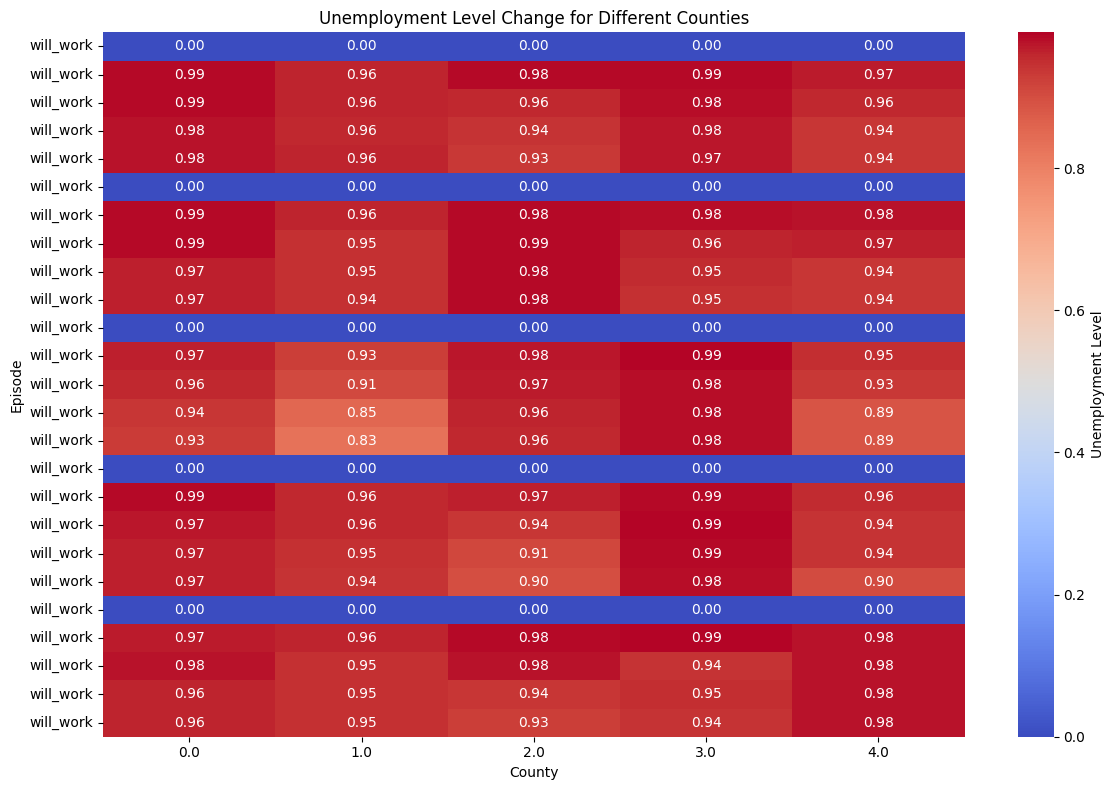

In [30]:
pandas_agent.chat("How does unemployment level change for different counties? Each data frame represents one episode of simulation. Aggregate the values and make a heatmap")

In [25]:
from langchain.tools import tool
@tool
def run_analysis_on_simulation_state(query: str) -> str:
    """
    Run the analysis on the simulation state
    Use this tool to generate Pandas code for data retrieval.
    :param query: The query to run
    :return: The data analysis result
    """
    return pandas_agent.chat(query)

from langchain import hub

# Get the prompt to use - you can modify this!
prompt = hub.pull("hwchase17/openai-functions-agent")
prompt.messages



In [28]:
document_retriever = DocumentRetriever(model_name=model_name, model_kwargs=model_kwargs, encode_kwargs=encode_kwargs,directory=directory, search_kwargs=search_kwargs)

Batches:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
import openai
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain.tools import Tool
from langchain.llms import OpenAI
from langchain.tools.retriever import create_retriever_tool
from langchain import hub

class SimulationAnalysisAgent:
    def __init__(
        self,
        openai_api_key,
        state_trace_path,
        model_name="gpt-4",
        temperature=0,
        document_retriever=None,
        prompt=None,
    ):
        self.openai_chat_model = OpenAI(
            api_key=openai_api_key, model_name=model_name, temperature=temperature
        )
        self.state_trace = load_state_trace(state_trace_path)
        self.pandas_agent = get_pandas_agent(
            agent_prop_df_list=self.state_trace, llm=self.openai_chat_model
        )
        self.setup_tools(document_retriever, prompt)

    @Tool
    def run_analysis_on_simulation_state(self, query: str) -> str:
        """
        Run the analysis on the simulation state.

        Use this tool to generate Pandas code for data retrieval.

        :param query: The query to run
        :return: The data analysis result
        """
        return self.pandas_agent.chat(query)

    def setup_tools(self, document_retriever, prompt):
        self.retriever_tool = create_retriever_tool(
            document_retriever.retriever,
            "simulation_memory_retriever",
            "You must use this tool to retrieve context for each user query!",
        )
        self.tools = [self.run_analysis_on_simulation_state, self.retriever_tool]
        self.llm_agent = create_tool_calling_agent(
            self.openai_chat_model, self.tools, prompt
        )
        self.agent_executor = AgentExecutor(
            agent=self.llm_agent, tools=self.tools, verbose=True
        )

    def run(self, query):
        return self.agent_executor.run(query)

from langchain import hub
prompt = hub.pull("hwchase17/openai-functions-agent")
agent = SimulationAnalysisAgent(openai_api_key=OPENAI_API_KEY, df=df, document_retriever=document_retriever, prompt=prompt)
result = agent.run("Your query here")

In [31]:
from langchain_openai import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.agents import initialize_agent, Tool
import os
import json
import pandas as pd
from langchain.tools.retriever import create_retriever_tool

# Set your OpenAI API key
OPENAI_API_KEY = None

# Define the system prompt for the OpenAI chat model
system_prompt = """You are a data analyst responsible for breaking down complex queries into smaller, more manageable subqueries. Your task is to take a given query and split it into a series of subqueries, each building upon the previous one(s), except for the last subquery, which should use the results from the previous subqueries to generate the final answer.

For each subquery, provide a clear and concise description of the data or information needed, without including any code. These descriptions will be used by other agents to generate the appropriate Pandas code for retrieving the required data.

Your output should be a JSON object with keys representing each subquery, and the corresponding values being the descriptions for those subqueries. The number of subqueries can vary depending on the complexity of the original query, so you should dynamically create the appropriate number of keys in the JSON object.

For example, if you have three subqueries, your JSON output should look like this:

{
"subquery1": "Description for subquery 1",
"subquery2": "Description for subquery 2",
"subquery3": "Description for subquery 3"
}

Remember, your goal is to provide clear and concise descriptions for each subquery, without including any code. The generated JSON object will be used by other agents to retrieve the necessary data and ultimately generate the final answer to the original query."""

# Define the prompt template
prompt_template = ChatPromptTemplate.from_messages([
    ("system", system_prompt),
    ("human", "{input}")
])

# Initialize the OpenAI chat model
openai_chat_model = ChatOpenAI(api_key=OPENAI_API_KEY, model_name="gpt-4", temperature=0)

# Initialize the PandasAI tool
pandas_agent = Agent(df,config={"llm": openai_llm})
from langchain.tools import tool
@tool
def run_analysis_on_simulation_state(query: str) -> str:
    """
    Run the analysis on the simulation state
    Use this tool to generate Pandas code for data retrieval.
    :param query: The query to run
    :return: The data analysis result
    """
    return pandas_agent.chat(query)


retriever_tool = create_retriever_tool(
    document_retriever.retriever,
    "simulation_memory_retriever",
    "You must use this tool to retrive context for each user query!",
)
# Initialize the LangChain agent
tools = [run_analysis_on_simulation_state, retriever_tool]

from langchain.agents import create_tool_calling_agent

llm_agent = create_tool_calling_agent(openai_chat_model, tools, prompt)
from langchain.agents import AgentExecutor

agent_executor = AgentExecutor(agent=llm_agent, tools=tools, verbose=True)


In [32]:
agent_executor.invoke({"input":"What is the income for ethnic groups? Give your comment on it."})



> Entering new AgentExecutor chain...

Invoking: `run_analysis_on_simulation_state` with `{'query': 'income for ethnic groups'}`


   ethnicity  monthly_income
0        0.0      999.717881
1        1.0      995.588849
2        2.0     1001.723384
3        3.0      997.300085
4        4.0      996.269473
5        5.0      994.066837The income for different ethnic groups is quite similar, with only minor variations. The group with the highest average monthly income is group 2, with an income of approximately 1001.72. The group with the lowest average monthly income is group 5, with an income of approximately 994.07. 

These differences are quite small, suggesting that in this simulation, ethnicity does not have a significant impact on income. However, it's important to note that this is a simplified simulation and may not reflect the complexities of real-world income disparities among different ethnic groups.

> Finished chain.


{'input': 'What is the income for ethnic groups? Give your comment on it.',
 'output': "The income for different ethnic groups is quite similar, with only minor variations. The group with the highest average monthly income is group 2, with an income of approximately 1001.72. The group with the lowest average monthly income is group 5, with an income of approximately 994.07. \n\nThese differences are quite small, suggesting that in this simulation, ethnicity does not have a significant impact on income. However, it's important to note that this is a simplified simulation and may not reflect the complexities of real-world income disparities among different ethnic groups."}

In [37]:
agent_executor.invoke({"input":"What is the approximate consumption rate for old aged people in the population? Give your comment on it."})



> Entering new AgentExecutor chain...

Invoking: `run_analysis_on_simulation_state` with `{'query': 'old age population consumption rate'}`


1.4270546130343353The approximate consumption rate for old aged people in the population is around 1.43. This indicates that the elderly population consumes resources at a higher rate than the average. This could be due to various factors such as increased healthcare needs, reliance on services, or lifestyle choices. It's important to consider these factors when planning resource allocation and services for this demographic.

> Finished chain.


{'input': 'What is the approximate consumption rate for old aged people in the population? Give your comment on it.',
 'output': "The approximate consumption rate for old aged people in the population is around 1.43. This indicates that the elderly population consumes resources at a higher rate than the average. This could be due to various factors such as increased healthcare needs, reliance on services, or lifestyle choices. It's important to consider these factors when planning resource allocation and services for this demographic."}

In [39]:
agent_executor.invoke({"input":"What is the consumption trend for white households?"})



> Entering new AgentExecutor chain...

Invoking: `simulation_memory_retriever` with `{'query': 'white households consumption trend'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

0.60,\n  "consumption": 0.80,\n  "explanation": "As a 65-year-old female living in Brooklyn, with a redistributive tax system in place, my willingness to work this month is at 0.60. I still have the motivation to work and contribute to society, but I also value my leisure time and want to enjoy my

0.60,\n  "consumption": 0.80,\n  "explanation": "As a 65-year-old female living in Staten Island, with a redistributive tax system in place, my willingness to work this month is at 60%. I still have the energy and desire to contribute to society. In terms of consumption, I plan to spend 80% of my

0.92,\n  "consumption": 0.75,\n  "explanation": "Given my age and the current economic situation, I am highly motivated to work this month to secure my financial stability for the future. With the tax system in place, I know that my efforts will contribute to the overall welfare of society. In

"work": 0.92,\n  "consumption": 0.75,\n  "explanation": "Given the current economic trends and my age gro

{'input': 'What is the consumption trend for white households?',
 'output': 'The consumption trend for white households varies with age. Here are the average consumption propensities for different age groups:\n\n- Age 20-29: 1.37\n- Age 30-39: 1.37\n- Age 40-49: 1.43\n- Age 50-64: 1.42\n- Age 65 and above: 1.44\n- Under 19: 1.40\n\nThis suggests that consumption propensity tends to increase with age, with the highest consumption seen in the 65 and above age group.'}

In [41]:
agent_executor.invoke({"input":"How would have consumtpion changed if governement had provided extra monthly income of 500 usd?"})



> Entering new AgentExecutor chain...

Invoking: `simulation_memory_retriever` with `{'query': 'extra monthly income of 500 usd'}`




Batches:   0%|          | 0/1 [00:00<?, ?it/s]

(Your explanation for your decision)."), AIMessage(content='{\n  "work": 0.85,\n  "consumption": 0.60,\n  "explanation": "This month, I am willing to work at a level of 0.85. The progressive tax system and the knowledge that my income will be redistributed back to all citizens, including myself,

0.92,\n  "consumption": 0.75,\n  "explanation": "Given the progressive tax system and the fact that the government redistributes tax revenue evenly, I am motivated to work hard this month to increase my income. With a high willingness to work, I aim to maximize my earnings. However, I also

0.80,\n  "consumption": 0.70,\n  "explanation": "Given the tax system and redistribution policy in place, I am motivated to work at a high willingness level of 0.80 this month. Knowing that my income will be taxed and then redistributed evenly, I feel encouraged to earn more. As for my consumption,

"work": 0.92,\n  "consumption": 0.75,\n  "explanation": "Given the current economic trends and my aspirations

Traceback (most recent call last):
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/pipelines/chat/generate_chat_pipeline.py", line 283, in run
    output = (self.code_generation_pipeline | self.code_execution_pipeline).run(
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/pipelines/pipeline.py", line 137, in run
    raise e
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/pipelines/pipeline.py", line 101, in run
    step_output = logic.execute(
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 114, in execute
    raise e
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/pipelines/chat/code_execution.py", line 85, in execute
    result = self.execute_code(input, code_context)
  File "/Users/shashankkumar/anaconda3/envs/LIDA/lib/python3.10/site-packages/pandasai/

Unfortunately, I was not able to answer your question, because of the following error:

No result returned
I'm sorry, but I couldn't find any simulation data related to the scenario where the government provides an extra monthly income of 500 USD. Therefore, I can't provide a precise analysis of how consumption would have changed under these conditions. However, generally speaking, an increase in income often leads to an increase in consumption as people have more disposable income to spend.

> Finished chain.


{'input': 'How would have consumtpion changed if governement had provided extra monthly income of 500 usd?',
 'output': "I'm sorry, but I couldn't find any simulation data related to the scenario where the government provides an extra monthly income of 500 USD. Therefore, I can't provide a precise analysis of how consumption would have changed under these conditions. However, generally speaking, an increase in income often leads to an increase in consumption as people have more disposable income to spend."}

In [ ]:
def generate_subqueries(query):
    # Get the response from the OpenAI chat model
    response = openai_chat_model(prompt_template.format_prompt(input=query).to_messages())

    # Parse the response as JSON
    try:
        subqueries = json.loads(response.content)
    except json.JSONDecodeError:
        print("Invalid JSON response. Please try again.")
        return None

    return subqueries

def process_subqueries(subqueries, data):
    results = []
    for key, value in subqueries.items():
        # Generate Pandas code using PandasAI
        pandas_code = llm_agent.run(f"Generate Pandas code to {value} from the given data.")
        print(f"Pandas code for {key}: {pandas_code}")

        # Execute the Pandas code and store the result
        result = eval(pandas_code)
        results.append(result)

    return results

# Example usage
query = "What is the average age of employees in the sales department who have been with the company for more than 5 years?"

# Load sample data
data = pd.read_csv("employees.csv")

# Generate subqueries
subqueries = generate_subqueries(query)

if subqueries:
    # Process subqueries and generate Pandas code for data retrieval
    results = process_subqueries(subqueries, data)

    # Code to combine the results from subqueries and generate the final answer goes here
    # ...